<a href="https://colab.research.google.com/github/keval2232/function_api_models_tensorflow/blob/main/Custom_losses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=50px color='red'>Huber_loss </font>

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

In [3]:
# inputs
xs = np.array([-1.0,  0.0, 1.0, 2.0, 3.0, 4.0], dtype=float)

# labels
ys = np.array([-3.0, -1.0, 1.0, 3.0, 5.0, 7.0], dtype=float)

In [ ]:
model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(xs, ys, epochs=500,verbose=0)

print(model.predict([10.0]))

[[18.976099]]


In [ ]:
def my_huber_loss(y_true, y_pred):
    threshold = 1
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= threshold
    small_error_loss = tf.square(error) / 2
    big_error_loss = threshold * (tf.abs(error) - (0.5 * threshold))
    return tf.where(is_small_error, small_error_loss, big_error_loss)

In [ ]:
model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss=my_huber_loss)
model.fit(xs, ys, epochs=500,verbose=0)
print(model.predict([10.0]))

[[18.792799]]


<font size=20px color='yellow'> Huber_loss_with_custom_thresold</font>

In [ ]:
def my_huber_loss_with_thresold(threshold):
  def my_huber_loss(y_true, y_pred):
    #threshold = 1
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= threshold
    small_error_loss = tf.square(error) / 2
    big_error_loss = threshold * (tf.abs(error) - (0.5 * threshold))
    return tf.where(is_small_error, small_error_loss, big_error_loss)
  return my_huber_loss

In [ ]:
model_ther=tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])
model_ther.compile(optimizer='sgd',loss=my_huber_loss_with_thresold(threshold=15.5))


In [ ]:
model_ther.fit(xs, ys, epochs=500,verbose=0)
print(model_ther.predict([10.0]))

[[18.81644]]


In [6]:
from tensorflow.keras.losses import Loss

class MyHuberLoss(Loss):
  
    # initialize instance attributes
    def __init__(self, threshold=1):
        super().__init__()
        self.threshold = threshold

    # compute loss
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= self.threshold
        small_error_loss = tf.square(error) / 2
        big_error_loss = self.threshold * (tf.abs(error) - (0.5 * self.threshold))
        return tf.where(is_small_error, small_error_loss, big_error_loss)

In [7]:
model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss=MyHuberLoss(threshold=1.02))
model.fit(xs, ys, epochs=500,verbose=0)
print(model.predict([10.0]))

[[18.592285]]


<h1>Constrative Loss </h1>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [2]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [3]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

4431872/4422102 [==============================] - 0s 0us/step


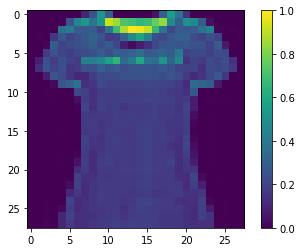

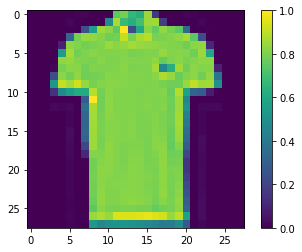

1.0


In [4]:
# array index
this_pair = 8

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair])

In [5]:
def initialize_base_network():
    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)
    

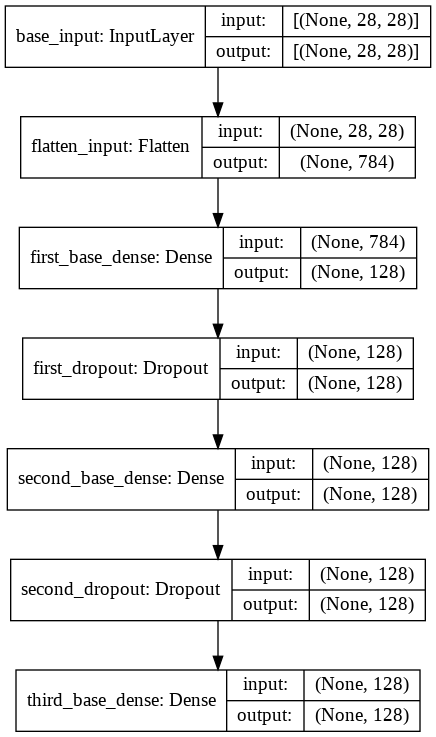

In [6]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

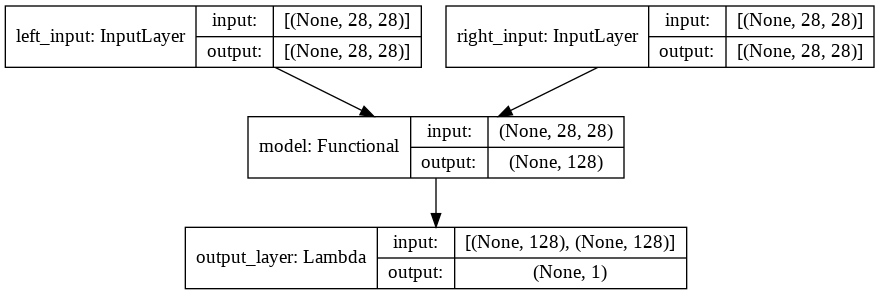

In [7]:
# create the left input and point to the base network
input_a = Input(shape=(28,28,), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

# plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

In [8]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [9]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 [==============================] - 8s 7ms/step - loss: 0.1116 - val_loss: 0.0824
Epoch 2/20
938/938 [==============================] - 6s 7ms/step - loss: 0.0808 - val_loss: 0.0738
Epoch 3/20
938/938 [==============================] - 6s 7ms/step - loss: 0.0726 - val_loss: 0.0726
Epoch 4/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0675 - val_loss: 0.0668
Epoch 5/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0642 - val_loss: 0.0671
Epoch 6/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0620 - val_loss: 0.0648
Epoch 7/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0604 - val_loss: 0.0653
Epoch 8/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0590 - val_loss: 0.0649
Epoch 9/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0582 - val_loss: 0.0649
Epoch 10/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0572 - val_loss: 0.0640